# KoBART 분류 참고

https://github.com/SKT-AI/KoBART/blob/main/examples/nsmc.py#L226

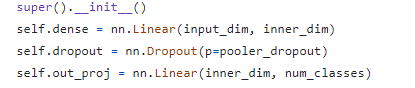

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split, DataLoader , Dataset , TensorDataset
from torchmetrics.regression import MeanSquaredError
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint

import os
import random

import pandas as pd
from transformers import BartModel
from kobert_tokenizer import KoBERTTokenizer
from transformers import DataCollatorWithPadding

from transformers.optimization import AdamW, get_cosine_schedule_with_warmup

from kobart import get_kobart_tokenizer, get_pytorch_kobart_model

In [15]:
class RM_Model(pl.LightningModule):
    def __init__(self):
        super().__init__()

        self.bart = BartModel.from_pretrained(get_pytorch_kobart_model())

        self.linear_1 = nn.Linear(768,  768)
        self.dropout = nn.Dropout(0.1)
        self.linear_2 = nn.Linear(768,  1)

        self.loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([8.1])) 


    def forward(self, input_ids, attention_mask):
        outputs = self.bart(
            input_ids=input_ids,
            attention_mask=attention_mask,
        )

        hidden_states = outputs.last_hidden_state
        eos_mask = input_ids.eq(1).to(hidden_states.device)
        sentence_representation = hidden_states[eos_mask, :].view(hidden_states.size(0), -1, hidden_states.size(-1))[:, -1, :]
        logits = self.linear_2(self.dropout(self.linear_1(sentence_representation)))
        return logits
    
    def training_step(self, batch, batch_idx):
        logits = self.forward(batch["input_ids"], batch["attention_mask"])
        loss = self.loss_fn(logits, batch["labels"])
        self.log_dict({'loss':loss})
        return loss
    
    def validation_step(self, batch, batch_idx):
        logits = self.forward(batch["input_ids"], batch["attention_mask"])
        loss = self.loss_fn(logits, batch["labels"])
        self.log_dict({'val_loss':loss})

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(),lr=0.02)
  

In [4]:
class News_Dataset(Dataset):
    def __init__(self,root_path):
        true_path = os.path.join(root_path,str(1))
        false_path = os.path.join(root_path,str(0))

        true_file_list = [os.path.join(true_path,f) for f in os.listdir(true_path)]
        false_file_list = [os.path.join(false_path,f) for f in os.listdir(false_path)]

        # 최종 파일경로 모음 및 라벨
        self.file_path = true_file_list + false_file_list
        self.label = [1 for _ in range(len(true_file_list))] + [0 for _ in range(len(false_file_list))]

        # 섞어주기
        data = list(zip(self.file_path, self.label))
        random.shuffle(data)
        self.file_path, self.label = zip(*data)

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        with open(self.file_path[idx], 'r') as file:
            title = file.readline().rstrip('\n')
            content = file.readline()

        return {'x':'<s>'+title+'<unused0>'+content+'</s>' , 'y': torch.tensor([self.label[idx]],dtype=torch.float)}


tokenizer = tokenizer = get_kobart_tokenizer()
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

def my_collate_fn(samples):
    '''
        [{'x':["<s>title_1<unused0>content_1</s>"] , 'y' : tensor([y1])},
         {'x':["<s>title_2<unused0>content_2</s>"] , 'y' : tensor([y2])} ... ]
    
    '''

    collate_y = [sample['y'] for sample in samples]
    collate_x = [sample['x'] for sample in samples]

    tokenized_x = data_collator(tokenizer.batch_encode_plus(collate_x))

    return {'input_ids': tokenized_x.input_ids,
            'attention_mask' : tokenized_x.attention_mask,
            'labels': torch.stack(collate_y)}

using cached model. c:\Users\minki\Desktop\Bigkinds_news_competition\.cache\kobart_base_tokenizer_cased_cf74400bce.zip


In [5]:
train_dataset = News_Dataset('./Dataset/train')
valid_dataset = News_Dataset('./Dataset/val')
test_dataset = News_Dataset('./Dataset/test')
len(train_dataset) , len(valid_dataset) , len(test_dataset)

(29934, 3300, 3300)

In [6]:
batch_size = 4
train_loader =  DataLoader(train_dataset,batch_size=batch_size,shuffle=True,collate_fn=my_collate_fn)
valid_loader = DataLoader(valid_dataset,batch_size=batch_size,shuffle=False,collate_fn=my_collate_fn)


logger = pl.loggers.CSVLogger("logs", name="RM_training1")
checkpoint_callback = ModelCheckpoint(
    save_top_k=5,
    monitor="val_loss",
    mode="min",
    filename="RM_Model-{epoch:02d}-{val_loss:.2f}",
)
trainer = pl.Trainer(max_epochs=1,logger=logger,accelerator="auto",
                     callbacks=checkpoint_callback,
                     log_every_n_steps=10
                     )
model = RM_Model()
trainer.fit(model,train_loader,valid_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.


using cached model. c:\Users\minki\Desktop\Bigkinds_news_competition\.cache\kobart_base_cased_ff4bda5738.zip


You are using a CUDA device ('NVIDIA GeForce RTX 3070 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Missing logger folder: logs\RM_training1
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type              | Params
-----------------------------------------------
0 | bart     | BartModel         | 123 M 
1 | linear_1 | Linear            | 590 K 
2 | dropout  | Dropout           | 0     
3 | linear_2 | Linear            | 769   
4 | loss_fn  | BCEWithLogitsLoss | 0     
-----------------------------------------------
124 M     Trainable params
0         Non-trainable params
124 M     Total params
497.805   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

c:\Users\minki\miniconda3\envs\dl_venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
You're using a PreTrainedTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
c:\Users\minki\miniconda3\envs\dl_venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` ini

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


In [7]:
trainer.save_checkpoint("1epoch.ckpt")

In [16]:
model = RM_Model.load_from_checkpoint("1epoch.ckpt")

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.


using cached model. c:\Users\minki\Desktop\Bigkinds_news_competition\.cache\kobart_base_cased_ff4bda5738.zip


In [ ]:
for name, param in model.named_parameters():
    print(name)

In [27]:
optimizer = AdamW(model.parameters(), lr=10, correct_bias=False)


c:\Users\minki\miniconda3\envs\dl_venv\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [33]:
optimizer.param_groups[0]['lr']

10

# 문제

0. 크롤링 기사 전처리 , 제목 , 본문 어떻게 할건지? , 스페셜 토큰

1. 다이나믹 패딩 collate에 적용

2. 얼마나 저장할지 에퐄마다?

3. 조기종료

4. 스케줄러? 안해도 될듯? 몰루

5. py파일로 변환 , arg 밑 도커 백그라운드

6. train_loss는 왜 저장안되는지

In [9]:
model.eval()
test_loader = DataLoader(test_dataset,batch_size=1,shuffle=True,collate_fn=my_collate_fn)
for test_data in test_loader:
    logit = model.forward(test_data["input_ids"], test_data["attention_mask"])
    #logit = nn.Sigmoid()(logit)
    print(f"실제 : 모델 => {test_data['labels'].item()} : {logit.item()}")

실제 : 모델 => 0.0 : -1.909703254699707
실제 : 모델 => 1.0 : -1.909703254699707
실제 : 모델 => 0.0 : -1.9097037315368652
실제 : 모델 => 0.0 : -1.9097037315368652
실제 : 모델 => 0.0 : -1.909703254699707
실제 : 모델 => 0.0 : -1.909703254699707
실제 : 모델 => 0.0 : -1.909703254699707
실제 : 모델 => 0.0 : -1.9097027778625488
실제 : 모델 => 0.0 : -1.9097037315368652
실제 : 모델 => 0.0 : -1.909703254699707


KeyboardInterrupt: 